In [2]:
import numpy as np
import shapely.geometry as geo
import shapely.affinity as aff

import sys
sys.path.append("../")
from electronfactors.ellipse.utilities import shapely_cutout, shapely_point

In [3]:
def test_min_distance(**kwargs):
    min_distance = kwargs['min_distance']
    point_of_interest = kwargs['point_of_interest']
    cutout = kwargs['cutout']
    
    is_within = cutout.contains(point_of_interest)
    
    distance = point_of_interest.distance(cutout.boundary)
    
    if not(is_within):
        return False
    
    elif distance < min_distance:
        return False
    
    else:
        return True

In [4]:
def furthest_possible_distance(point_of_interest, cutout):
    x = point_of_interest.xy[0][0]
    y = point_of_interest.xy[1][0]
    
    translated_cutout = aff.translate(cutout, xoff=-x, yoff=-y)
    max_bound = np.max(np.abs(translated_cutout.boundary))
    furthest_distance = max_bound * np.sqrt(2)
    
    return furthest_distance

In [93]:
def make_rays(point_of_interest, cutout, num_rays):
    x_POI = point_of_interest.xy[0][0]
    y_POI = point_of_interest.xy[1][0]
    
    ray_length = furthest_possible_distance(point_of_interest, cutout)
    theta = np.random.uniform(0, 2*np.pi, size=num_rays)
      
    x_points = x_POI + ray_length * np.cos(theta)
    y_points = y_POI + ray_length * np.sin(theta)
    
    coords = [((x_POI, y_POI), (x_points[i], y_points[i])) for i in range(num_rays)]
    rays = geo.MultiLineString(coords)
    
    return rays

In [340]:
def determine_line_segmentation(distances):
    
    begin_at_POI = np.array([distances[i][0] == 0.0 for i in range(len(distances))])
    
    segment_groups_indices  = []
    full_lines_index = np.arange(len(begin_at_POI)).astype('float')

    for i in range(1, len(begin_at_POI)):

        if (~begin_at_POI[i]) & (begin_at_POI[i-1]):
            j = int(i)
            new_segment = [j - 1]
            full_lines_index[j - 1] = np.nan

            while ~(begin_at_POI[j]):
                new_segment.append(j)
                full_lines_index[j] = np.nan
                j += 1
                if j == len(begin_at_POI):
                    break

            segment_groups_indices.append(new_segment)

    full_lines_index = full_lines_index[~np.isnan(full_lines_index)].astype('int')  

    return full_lines_index, segment_groups_indices

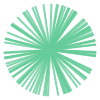

In [148]:
rays = make_rays(point_of_interest, cutout, 100)
rays

In [6]:
# Split each ray into a series of points. 
# Test whether each point on the ray is inside the cutout or outside the cutout. 
# If there are groups of points in or out of the cutout, the last most of those points is taken as representative
# and used for the "sector integration".

# This method is slower... but more reliable.


# Don't need to do this. 


# Use the intersection method to break the line up into groups.
# Detect which line segments are within. For each "within" take away the beginning and add the end.

In [341]:
def sector_integration(num_rays=1000, **kwargs):    
    x = kwargs['x']
    y = kwargs['y']
    circle_fit = kwargs['circle_fit']
    min_distance = kwargs['min_distance']
    point_of_interest = shapely_point(*kwargs['point_of_interest'])
    
    cutout = shapely_cutout(x, y)
    
    if not(test_min_distance(min_distance=min_distance, 
                             point_of_interest=point_of_interest,
                             cutout=cutout)):
        raise Exception("Point of interest is too close to edge or is outside of cutout")
    
    rays = make_rays(point_of_interest, cutout, num_rays)
    intersection = cutout.intersection(rays)
    
    line_ends = [
        geo.MultiPoint(intersection[i].coords) for i in range(len(intersection))
    ]
    
    distances = [
        [
            line_ends[j][i].distance(point_of_interest) for i in range(2)
        ] for j in range(len(intersection))
    ]
    
    full_lines_index, segment_groups_indices = determine_line_segmentation(distances)
    
    ray_factor = []
    for i in full_lines_index:
        ray_factor.append(circle_fit(distances[i][1]) - circle_fit(distances[i][0]))

    for item in segment_groups_indices:
        new_segment_factor = []
        for i in item:
            new_segment_factor.append(circle_fit(distances[i][1]) - circle_fit(distances[i][0]))

        ray_factor.append(np.sum(new_segment_factor))
    
    factor = np.mean(ray_factor)
    
    return factor
    

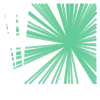

In [250]:
rays = make_rays(point_of_interest, cutout, 100)

intersection = cutout.intersection(rays)
intersection

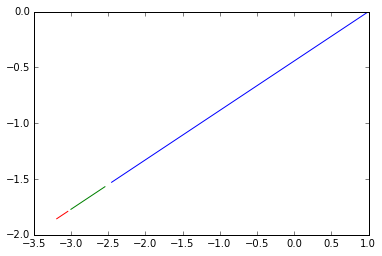

In [342]:
x = [intersection[i].xy[0] for i in segment_groups[0]]
y = [intersection[i].xy[1] for i in segment_groups[0]]

for i in range(len(x)):
    plt.plot(x[i], y[i])

In [260]:
begin_at_POI = np.array([distances[i][0] == 0.0 for i in range(len(distances))])

In [343]:
segment_groups_indices  = []
full_lines_index = np.arange(len(begin_at_POI)).astype('float')

for i in range(1, len(begin_at_POI)):

    if (~begin_at_POI[i]) & (begin_at_POI[i-1]):
        j = int(i)
        new_segment = [j - 1]
        full_lines_index[j - 1] = np.nan

        while ~(begin_at_POI[j]):
            new_segment.append(j)
            full_lines_index[j] = np.nan
            j += 1
            if j == len(begin_at_POI):
                break

        segment_groups_indices.append(new_segment)

full_lines_index = full_lines_index[~np.isnan(full_lines_index)].astype('int')    

In [353]:
ray_factor = []

for i in full_lines_index:
    ray_factor.append(circle_fit(distances[i][1]) - circle_fit(distances[i][0]))
    
for item in segment_groups_indices:
    new_segment_factor = []
    for i in item:
        new_segment_factor.append(circle_fit(distances[i][1]) - circle_fit(distances[i][0]))
        
    ray_factor.append(np.sum(new_segment_factor))

In [358]:
ray_factor

[0.99146920560613827,
 0.98899798478052958,
 0.98876296883642523,
 1.0050430603479181,
 0.98844032048953723,
 0.9921259794789653,
 0.99109564893125768,
 1.0022849953077704,
 0.95290531653939392,
 0.98143737303934397,
 0.99209935050721809,
 1.0019960413753026,
 0.9900624784897647,
 0.9918626210981305,
 1.0004014163268626,
 0.98959554425515428,
 0.96786157773115211,
 0.97765292256222525,
 0.97123283800059834,
 0.99123501693103511,
 0.99649708056275776,
 0.95420583709138385,
 0.98853006809504718,
 0.99301875780300841,
 0.99835811050593848,
 1.0057115688025133,
 0.95585351919043804,
 0.96653290644768464,
 0.99117342585830626,
 1.0017612377052285,
 1.0024109083893127,
 0.98858808274203369,
 0.99448274632080447,
 0.98845237385012752,
 0.99133226574096223,
 0.98857139344156764,
 0.98844404467662228,
 0.98997579832362248,
 0.9597431026570663,
 1.008631057328756,
 0.97414190918140919,
 0.99574220039944006,
 0.99102403527258254,
 0.9640018290344945,
 1.0084,
 0.9926818782412038,
 0.9620424927678

In [357]:
ray_factor
factor = np.mean(ray_factor)
factor

0.99000420413723544

In [356]:
len(ray_factor)

100

In [195]:
# Need to treat broken segments differently so that they don't get double weighted

distances

[[0.0, 3.002981313376328],
 [0.0, 4.293134563790944],
 [4.380918645045425, 4.53514894948998],
 [0.0, 4.00304300824735],
 [4.437975840846579, 4.532897705805534],
 [0.0, 2.018480580274724],
 [0.0, 2.60800763948078],
 [0.0, 2.068987577831144],
 [0.0, 3.166201998062704],
 [0.0, 4.033600016088979],
 [0.0, 3.123848350962977],
 [0.0, 4.071834447311529],
 [4.314740723660286, 4.4399436864585615],
 [0.0, 3.187274068582428],
 [0.0, 2.1769876190175688],
 [0.0, 4.082355300672352],
 [4.681565540976177, 4.754266715892976],
 [0.0, 3.5626534100018774],
 [0.0, 4.090220103975804],
 [4.700013076810479, 4.771346033640097],
 [0.0, 3.1296124582120908],
 [0.0, 2.685683302771466],
 [0.0, 3.1128898985723357],
 [0.0, 2.5732656146646464],
 [0.0, 2.5384468290930506],
 [0.0, 3.5444981930946953],
 [0.0, 2.0191700729584796],
 [0.0, 3.0001422985693647],
 [0.0, 3.314751717355237],
 [0.0, 2.7730113496857642],
 [0.0, 2.0007222058837875],
 [0.0, 2.0199932942541547],
 [0.0, 2.124095585318482],
 [0.0, 4.655052932477504],
 [

In [ ]:
for i, item in enumerate(distances):
    

In [153]:
test = distances[0]

circle_fit(test[1]) - circle_fit(test[0])

1.0088174264379086

In [146]:
circle_fit(test[1])

array(0.0)

In [246]:
import numpy as np
from scipy.interpolate import UnivariateSpline

from electronfactors.ellipse.sectorintegration import SectorIntegration

x = np.array([-3, -2.5, -2, 3, 3, -3, -4, -3])
y = np.array([3, -2, 3, 3, -3, -3, 3, -2])

circle_diameter = np.array([3, 4, 5, 6, 7, 8, 9])
circle_factors = np.array(
    [0.9296, 0.9562, 0.9705, 0.9858, 1.0032, 1.0067, 1.0084])


def circle_fit(radii):

    circle_radii = circle_diameter/2

    spline = UnivariateSpline(circle_radii, circle_factors)
    results = spline(radii)

    results[radii > np.max(circle_radii)] = np.max(circle_factors)
    results[radii < np.min(circle_radii)] = 0

    return results

In [247]:
sector_integration(min_distance=1.5, point_of_interest=[1,0], x=x, y=y, circle_fit=circle_fit)

In [248]:
cutout = shapely_cutout(x, y)

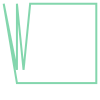

In [249]:
cutout.boundary

In [147]:
point_of_interest = shapely_point(*[1,0])
test_min_distance(min_distance=1, point_of_interest=point_of_interest, cutout=cutout)

True

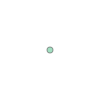

In [15]:
point_of_interest

In [16]:
point_of_interest.distance(cutout.boundary)

0.9990000000000001

In [17]:
point_of_interest.xy[0][0]

2.001

In [18]:
np.random.uniform(0, 2*np.pi, size=100)

array([ 2.90845814,  5.34639087,  0.9299234 ,  3.82273036,  1.39610238,
        1.18348401,  1.70011849,  0.28548805,  3.68589668,  3.65829489,
        3.64529937,  3.04673702,  6.11509528,  5.53747428,  2.53368616,
        4.02838526,  3.13449773,  0.48396414,  0.59317121,  3.38340764,
        2.42681998,  1.00417931,  2.93804123,  0.80417449,  2.67336579,
        5.52760143,  1.95889064,  3.91016959,  0.49612328,  2.08720527,
        1.18865761,  0.08314679,  6.15386657,  5.07126653,  2.91775658,
        5.73497167,  0.92793005,  4.12035116,  2.89068495,  4.38981521,
        4.0711826 ,  6.2071406 ,  6.02923516,  3.23733325,  1.74398652,
        2.44116737,  0.32661723,  5.33026276,  0.29877718,  6.05847843,
        3.4209143 ,  4.33970181,  3.07530423,  5.09223199,  3.41535695,
        6.08305025,  5.86412814,  5.35445934,  3.77372724,  0.87672523,
        4.9333173 ,  4.95065947,  0.88993091,  0.98012378,  2.96936991,
        0.18478349,  0.9894035 ,  0.14335006,  4.55886042,  5.68

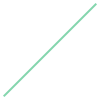

In [19]:
geo.LineString(((0, 0), (1, 1)))


In [20]:
a = np.array([1,2,3,4])[np.newaxis]
b = np.array([1,2,3])[np.newaxis].T

a * b

array([[ 1,  2,  3,  4],
       [ 2,  4,  6,  8],
       [ 3,  6,  9, 12]])

In [21]:
np.array([5,4])

array([5, 4])

In [22]:
a

array([[1, 2, 3, 4]])

In [23]:
x_points, y_points = make_rays(point_of_interest, cutout, 100)



In [24]:
import matplotlib.pyplot as plt
from matplotlib import pylab
%matplotlib inline


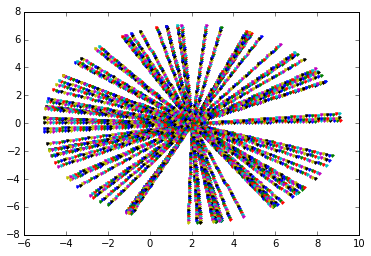

In [25]:
dim = np.shape(x_points)

for i in range(dim[0]):
    for j in range(dim[1]):

        plt.plot(x_points[i, j], y_points[i, j], '.')

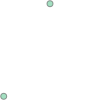

In [26]:
geo.MultiPoint([(0,0),(1,2)])

In [79]:
x_points, y_points = make_rays(point_of_interest, cutout, 100, 500)


dim = np.shape(x_points)

rays = [[(x_points[i, j], y_points[i, j]) for j in range(dim[1])] for i in range(dim[0])]
    
shapely_rays = [geo.MultiPoint(item) for item in rays]

bar = [[cutout.contains(point) for point in ray] for ray in shapely_rays]

bar

[[True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,


In [67]:
shapely_rays = [geo.MultiPoint(item) for item in rays]

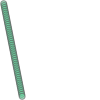

In [68]:
shapely_rays[0]

In [73]:
bar = [[
    cutout.contains(point) for point in ray
    ] for ray in shapely_rays]

bar

[[True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False],
 [True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False],
 [True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True

In [39]:
 test_list[i][j] = x_points[i, j], y_points[i, j]

In [ ]:
twod_list = []     
for i in range (0, 10): 
    new = []    
    for j in range (0, 10):   
        new.append(foo) 
    twod_list.append(new)